# I. Explore Dataset

In [1]:
%%capture
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
def show_images(images, titles=None):
    if not titles:
        titles = [img.shape for img in images]
    fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(10, 30))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap="summer")
        ax.set_title(titles[i])
        ax.axis("off")
    plt.show()

In [3]:
root_path = "/kaggle/input/vatsaikhlongsaphansung/VatSaiKhlongSaphanSung+V280" #enter dataset path
categories_paths = os.listdir(root_path)
categories_paths = [os.path.join(root_path, cat_path) for cat_path in categories_paths]

In [4]:
total_images = 0
for cat_path in categories_paths:
    for _, _, files in os.walk(cat_path):
        print("{}: {}".format(cat_path, len(files)))
        total_images=total_images+len(files)
print('Total images:',total_images/2,'/ Total masks:',total_images/2)

/kaggle/input/vatsaikhlongsaphansung/VatSaiKhlongSaphanSung+V280/VatSaiKhlongSaphanSung_158: 56
/kaggle/input/vatsaikhlongsaphansung/VatSaiKhlongSaphanSung+V280/VatSaiKhlongSaphanSung_51: 20
/kaggle/input/vatsaikhlongsaphansung/VatSaiKhlongSaphanSung+V280/VatSaiKhlongSaphanSung_115: 88
/kaggle/input/vatsaikhlongsaphansung/VatSaiKhlongSaphanSung+V280/VatSaiKhlongSaphanSung_50: 44
/kaggle/input/vatsaikhlongsaphansung/VatSaiKhlongSaphanSung+V280/VatSaiKhlongSaphanSung_7: 20
/kaggle/input/vatsaikhlongsaphansung/VatSaiKhlongSaphanSung+V280/VatSaiKhlongSaphanSung_48: 26
/kaggle/input/vatsaikhlongsaphansung/VatSaiKhlongSaphanSung+V280/VatSaiKhlongSaphanSung_162: 152
/kaggle/input/vatsaikhlongsaphansung/VatSaiKhlongSaphanSung+V280/VatSaiKhlongSaphanSung_95: 38
/kaggle/input/vatsaikhlongsaphansung/VatSaiKhlongSaphanSung+V280/VatSaiKhlongSaphanSung_8: 20
/kaggle/input/vatsaikhlongsaphansung/VatSaiKhlongSaphanSung+V280/VatSaiKhlongSaphanSung_29: 22
/kaggle/input/vatsaikhlongsaphansung/VatSaiKhlon

# II. Dataset Preparation

In this part, we should take care of several things:
* Creating a generator to read images from memory on the fly (during training).
* Spliting the dataset into train and test for further evaluation.
* Creating two datasets from the generators

In [5]:
import re

def numerical_key(string):
        # Extract all numbers from the string and convert them to integers
        return [int(num) if num.isdigit() else num for num in re.split(r'(\d+)', string)]

In [6]:
images_paths = []
for cat_path in categories_paths:
    for root, _, files in os.walk(cat_path):
        cd_images = [os.path.join(root, file) for file in files]
        [images_paths.append(img) for img in cd_images]
images_paths = sorted(images_paths, key=numerical_key)
images_paths[:6]

['/kaggle/input/vatsaikhlongsaphansung/VatSaiKhlongSaphanSung+V280/V280/village_A1_tile_0_0.png',
 '/kaggle/input/vatsaikhlongsaphansung/VatSaiKhlongSaphanSung+V280/V280/village_A1_tile_0_0_mask.png',
 '/kaggle/input/vatsaikhlongsaphansung/VatSaiKhlongSaphanSung+V280/V280/village_A1_tile_0_1024.png',
 '/kaggle/input/vatsaikhlongsaphansung/VatSaiKhlongSaphanSung+V280/V280/village_A1_tile_0_1024_mask.png',
 '/kaggle/input/vatsaikhlongsaphansung/VatSaiKhlongSaphanSung+V280/V280/village_A1_tile_512_0.png',
 '/kaggle/input/vatsaikhlongsaphansung/VatSaiKhlongSaphanSung+V280/V280/village_A1_tile_512_0_mask.png']

In [7]:
len(images_paths)

2014

We can see that the images are in the odd indices and their mask is in the next index, so knowing this structure, we will divide the indices to `train_idx`, `val_idx` and `test_idx` and then create these generators:

In [8]:
n_images = len(images_paths)
new_size = (512, 512)
images_idx = range(0, n_images, 2)
train_idx, temp_idx = train_test_split(images_idx, test_size=0.2, random_state=37)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=37)

In [9]:
print("Train indexes:", train_idx, "\n")
print("Validation indexes:", val_idx, "\n")
print("Test indexes:", test_idx, "\n")

Train indexes: [986, 1266, 776, 566, 1298, 1384, 1534, 1892, 1678, 60, 1986, 568, 752, 1722, 1790, 304, 1760, 32, 1182, 1028, 234, 1374, 266, 1202, 1348, 890, 1604, 148, 1970, 154, 484, 1922, 1014, 54, 1316, 1484, 424, 674, 1170, 178, 444, 1564, 834, 1258, 1824, 140, 880, 372, 120, 1228, 738, 656, 1594, 1536, 156, 218, 1398, 1848, 1984, 28, 1514, 186, 1962, 638, 542, 644, 988, 1050, 430, 1212, 822, 1214, 580, 1120, 1542, 1660, 1576, 1740, 1032, 2012, 800, 1458, 1898, 242, 1654, 480, 1248, 536, 260, 772, 962, 1400, 1486, 410, 1830, 1096, 1580, 1408, 442, 1060, 1088, 1700, 952, 402, 572, 1890, 308, 1404, 1492, 1414, 1474, 282, 1230, 1362, 662, 978, 790, 504, 192, 1340, 1144, 428, 1406, 196, 1326, 744, 336, 560, 1470, 416, 438, 720, 1162, 250, 280, 1496, 1116, 362, 1918, 1776, 2004, 1868, 810, 1424, 980, 1590, 1702, 1480, 1442, 1172, 1104, 1812, 1336, 1190, 636, 946, 906, 72, 528, 1510, 1936, 696, 1226, 330, 1158, 486, 1074, 34, 1770, 1504, 588, 1802, 268, 1940, 1624, 1766, 1432, 366, 204

In [10]:
print('train:',len(train_idx),'/ validation:',len(val_idx),'/ test:',len(test_idx), '/ total:',len(train_idx)+len(val_idx)+len(test_idx))

train: 805 / validation: 101 / test: 101 / total: 1007


Create generator for train and test

In [11]:
%%capture
!pip install -U -q segmentation-models
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
import albumentations as A

In [12]:
backbone = 'inceptionresnetv2'
batch_size = 16

In [13]:
backbone_preprocess = sm.get_preprocessing(backbone)

In [14]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomResizedCrop(height=new_size[0], width=new_size[1], scale=(0.8, 1.0), p=0.5),
    A.Rotate(limit=40, p=0.5),
    
#     Uncomment one line below to use a specific image enhancement algorithm (make sure to uncomment the same enhancement in 'test_val_transform' too)
#     A.RandomGamma(gamma_limit=(80,80),p=1),
#     A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1)
#     A.Equalize(mode='cv', by_channels=True, p=1),
    
#     Uncomment to make model predictions detached from colors and only rely on patterns (It works but model performace suffers when I was testing it)
#     A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
#     A.ChannelShuffle(p=0.9),
#     A.InvertImg(p=0.5)
])

test_val_transform = A.Compose([
#     A.RandomGamma(gamma_limit=(80,80),p=1),
#     A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1)
#     A.Equalize(mode='cv', by_channels=True, p=1),
])


In [15]:
def train_dataset_generator():
    for i in train_idx:
        image = (
            tf.convert_to_tensor(plt.imread(images_paths[i])*255, dtype=tf.float32)
        )
        mask = (
            tf.convert_to_tensor(
                np.expand_dims(plt.imread(images_paths[i + 1])*255, axis=(-1)),
                dtype=tf.float32,
            )
            
        )
        
        # Convert image and mask to NumPy arrays
        image = np.array(image, dtype=np.uint8)
        mask = np.array(mask, dtype=np.uint8)
        
        # Apply Albumentations transformations
        augmented = transform(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        
        image = backbone_preprocess(image)
        
        yield tf.convert_to_tensor(image, dtype=tf.float32), tf.convert_to_tensor(mask, dtype=tf.float32)

def validation_dataset_generator():
    for i in val_idx:
        image = (
            tf.convert_to_tensor(plt.imread(images_paths[i])*255, dtype=tf.float32)
        )
        mask = (
            tf.convert_to_tensor(
                np.expand_dims(plt.imread(images_paths[i + 1])*255, axis=(-1)),
                dtype=tf.float32,
            )
            
        )

        # Convert image and mask to NumPy arrays
        image = np.array(image, dtype=np.uint8)
        mask = np.array(mask, dtype=np.uint8)
        
        # Apply Albumentations transformations
        augmented = test_val_transform(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        
        image = backbone_preprocess(image)
        
        yield tf.convert_to_tensor(image, dtype=tf.float32), tf.convert_to_tensor(mask, dtype=tf.float32)
        

def test_dataset_generator():
    for i in test_idx:
        image = (
            tf.convert_to_tensor(plt.imread(images_paths[i])*255, dtype=tf.float32)
        )
        mask = (
            tf.convert_to_tensor(
                np.expand_dims(plt.imread(images_paths[i + 1])*255, axis=(-1)),
                dtype=tf.float32,
            )
            
        )
        
        # Convert image and mask to NumPy arrays
        image = np.array(image, dtype=np.uint8)
        mask = np.array(mask, dtype=np.uint8)
        
        # Apply Albumentations transformations
        augmented = test_val_transform(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        
        image = backbone_preprocess(image)
        

        yield tf.convert_to_tensor(image, dtype=tf.float32), tf.convert_to_tensor(mask, dtype=tf.float32)

Create tensorflow datasets:

In [16]:
train_dataset = tf.data.Dataset.from_generator(
    train_dataset_generator,
    output_signature=(
        tf.TensorSpec(shape=(*new_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(*new_size, 1), dtype=tf.float32),
    ),
)

valid_dataset = tf.data.Dataset.from_generator(
    validation_dataset_generator,
    output_signature=(
        tf.TensorSpec(shape=(*new_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(*new_size, 1), dtype=tf.float32),
    ),
)

test_dataset = tf.data.Dataset.from_generator(
    test_dataset_generator,
    output_signature=(
        tf.TensorSpec(shape=(*new_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(*new_size, 1), dtype=tf.float32),
    ),
)


Next, we wil check if the dataset is working properly or not.

From train set


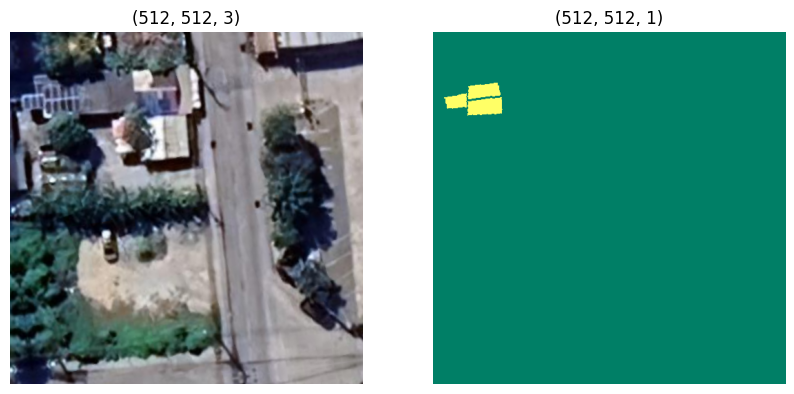

From validation set


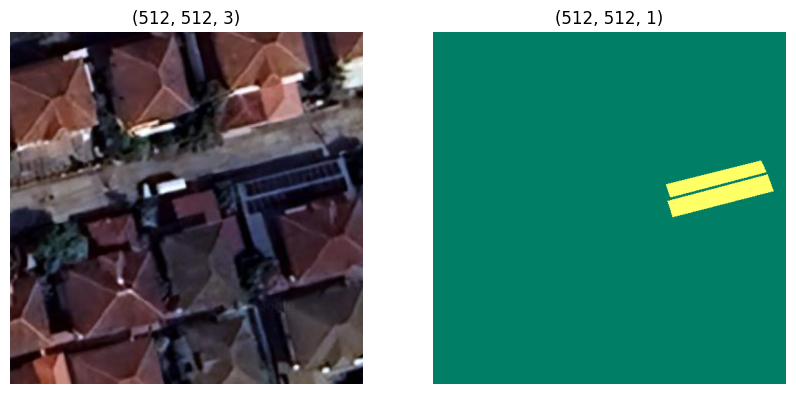

From test set


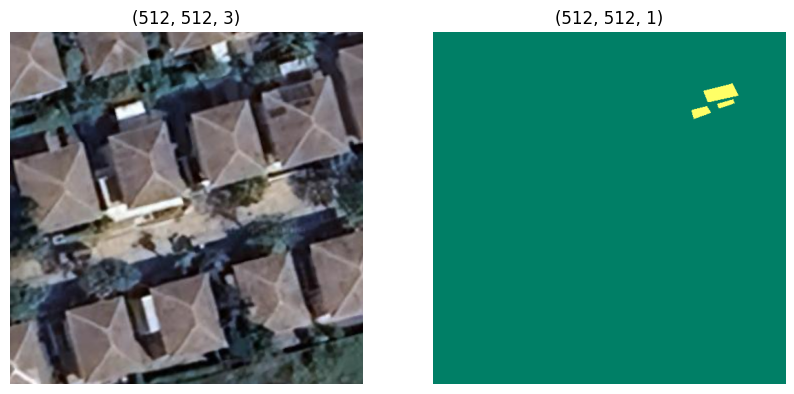

In [17]:
print("From train set")
for item in train_dataset.take(1):
    show_images(((item[0] + 1) / 2,item[1]))
print("From validation set")  
for item in test_dataset.take(1):
    show_images(((item[0] + 1) / 2,item[1]))
print("From test set")  
for item in valid_dataset.take(1):
    show_images(((item[0] + 1) / 2,item[1]))


In [18]:
train_dataset = train_dataset.batch(batch_size)
valid_dataset = valid_dataset.batch(batch_size)

# III. UNet Model

We will be utilizing the segmentation-models library to obtain a Unet model with a inceptionresnetv2 backbone. The Unet model is pretrained on the ImageNet dataset: https://www.image-net.org/

In [19]:
def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

def combined_dice_jaccard_loss(y_true, y_pred):
    alpha = 0.6
    
    # Dice Loss
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice_loss = 1 - (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

    # Jaccard Loss
    jaccard_loss = sm.losses.JaccardLoss()(y_true, y_pred)
    
    # Combined Loss
    combined_loss = alpha * dice_loss + (1 - alpha) * jaccard_loss
    return combined_loss

In [20]:
load_model = True

In [21]:
if load_model:
    print("load model")
    model_path = "/kaggle/input/inceptionresnetv2_ensemble/keras/default/3/model_unet-inceptionresnetv2_mixLoss_06_IOU_07458.keras" #load model here
    model = keras.models.load_model(
        model_path,
        custom_objects={
            "combined_dice_jaccard_loss": combined_dice_jaccard_loss,
            "iou_score": sm.metrics.IOUScore(),
            "dice_coef": dice_coef,
        },
    )
else:
    print("create model")
    model = sm.Unet(
        backbone,
        input_shape=(512, 512, 3),
        classes=1,
        encoder_weights="imagenet",
        encoder_freeze=True,
    )
    loss = combined_dice_jaccard_loss
    metrics = [sm.metrics.IOUScore(),dice_coef,'binary_accuracy',keras.metrics.Precision(),keras.metrics.Recall()]
    model.compile("Adam", loss=loss, metrics=metrics)
    

load model


In [22]:
#keras.utils.plot_model(model, show_shapes=True) # Uncomment for seeing the model graph

# IV. Training Model

In this part we will train the model.
First we define a callback for visualize the learning process with one instance of the training dataset. 

In [23]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:
            for item in train_dataset.unbatch().shuffle(1).take(1):
                image = item[0]
                mask_4d = self.model.predict(np.expand_dims(image, axis=(0)))
                mask = np.squeeze(mask_4d, axis=0)
                image_converted = (image + 1) / 2 #revert backbone preprocessing for inceptionV3 and inceptionresnetV2 for viewing purposes only (doesn't work very well with efficientnetb7)
                show_images((image_converted, mask))

display_cb = DisplayCallback()
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights='True')
checkpoint_cb = keras.callbacks.ModelCheckpoint('model_unet-'+backbone+'_cp.keras', verbose=1, save_best_only=True)

The following code will train the model. In the case of training on the our dataset it will take around 20-30 minutes running on a P100 GPU with kaggle.

In [24]:
if not load_model:
    with tf.device("/device:GPU:0"):
        history = model.fit(
            train_dataset,
            batch_size=batch_size,
            epochs=200,
            validation_data=valid_dataset,
            callbacks=[display_cb, early_stopping_cb, checkpoint_cb],
        )
    history = pd.DataFrame.from_dict(history.history)

    history.to_csv("history_unet-"+backbone+".csv", index=False)
    model.save("model_unet-"+backbone+".keras")


Let's take a look on train and validation loss and IoU score:

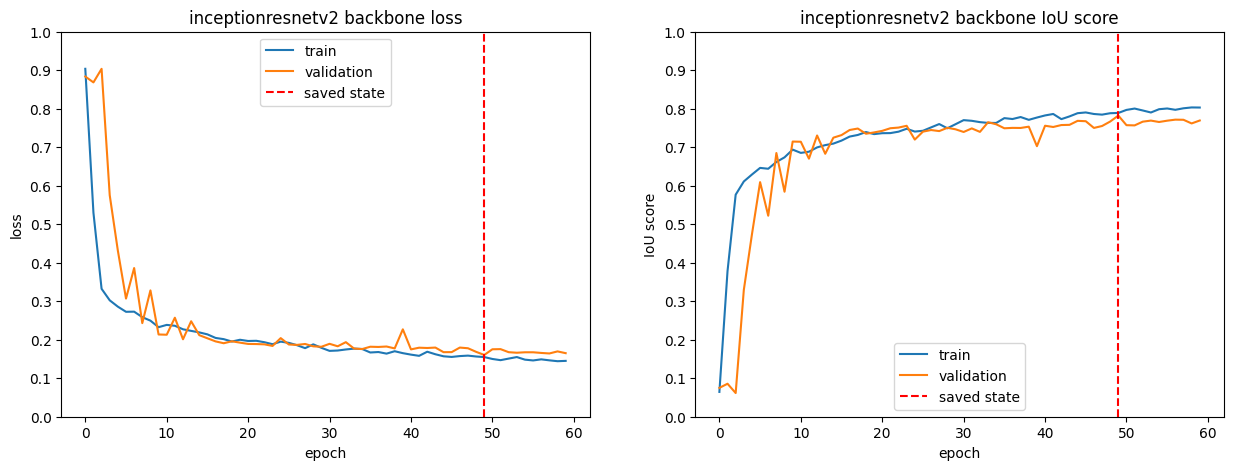

In [25]:
if load_model:
    history = pd.read_csv('/kaggle/input/model-history/history_unet-inceptionresnetv2.csv')


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='validation')
plt.title(backbone+ ' backbone loss')
plt.ylabel('loss')
plt.xlabel('epoch')

# Generate y-ticks from 0 to the maximum value with a step of 0.1
max_y = 1
plt.yticks(np.arange(0, max_y + 0.1, 0.1))

# Find the x position where val_loss is highest
max_val_loss_index = np.argmin(history['val_loss'])

# Add a dashed vertical line at that position
plt.axvline(x=max_val_loss_index, color='r', linestyle='--', label='saved state')

plt.legend(loc='upper center')

plt.subplot(1, 2, 2)
plt.plot(history['iou_score'], label='train')
plt.plot(history['val_iou_score'], label='validation')
plt.title(backbone+ ' backbone IoU score')
plt.ylabel('IoU score')
plt.xlabel('epoch')

# Set y-axis limits
# Generate y-ticks from 0 to the maximum value with a step of 0.1
max_y = 1
plt.yticks(np.arange(0, max_y + 0.1, 0.1))

# Find the x position where val_loss is highest
max_val_loss_index = np.argmin(history['val_loss'])

# Add a dashed vertical line at that position
plt.axvline(x=max_val_loss_index, color='r', linestyle='--', label='saved state')

plt.legend(loc='lower center')

plt.show()

# V. Evaluate Model

We will evaluate the model. Doing this, we will take 10 instances from test set and see the result, note that the model has never seen these images.

1/1 [==============================] - 8s 8s/step


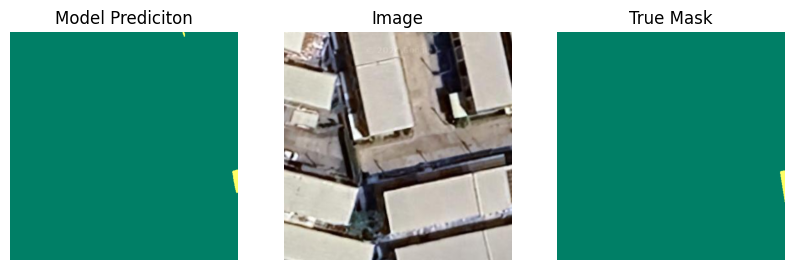

1/1 [==============================] - 0s 48ms/step


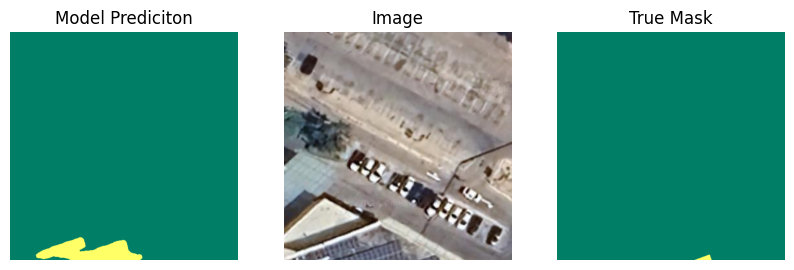

1/1 [==============================] - 0s 45ms/step


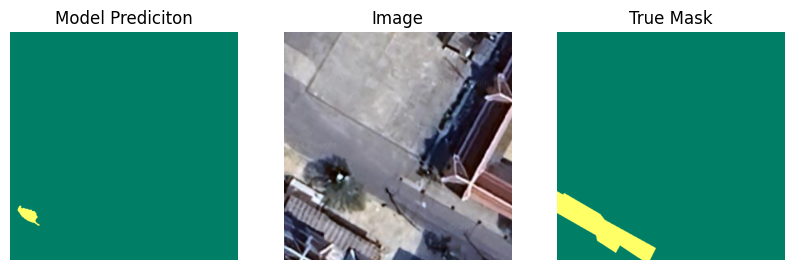

1/1 [==============================] - 0s 46ms/step


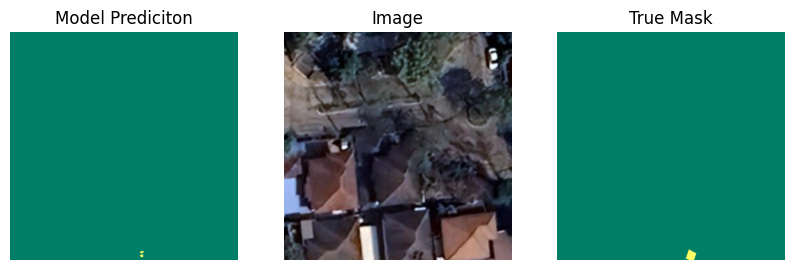

1/1 [==============================] - 0s 46ms/step


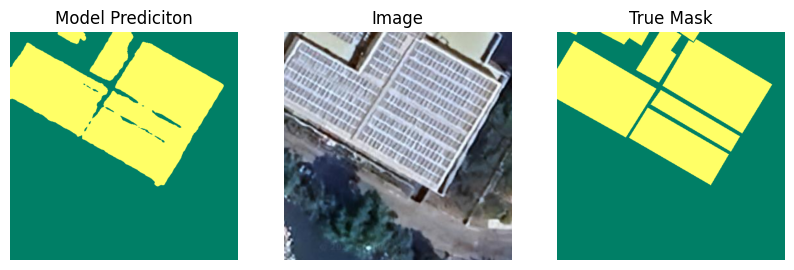

1/1 [==============================] - 0s 48ms/step


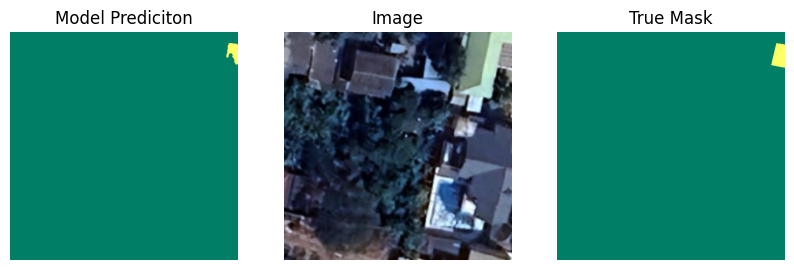

1/1 [==============================] - 0s 46ms/step


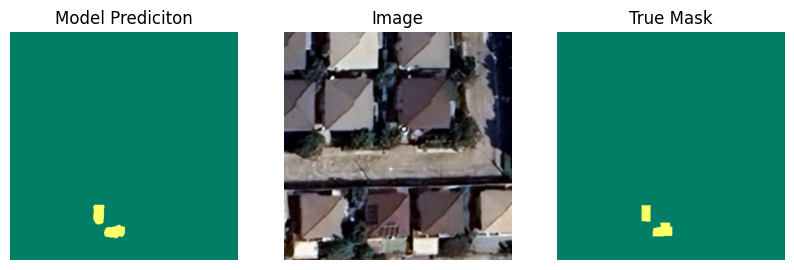

1/1 [==============================] - 0s 47ms/step


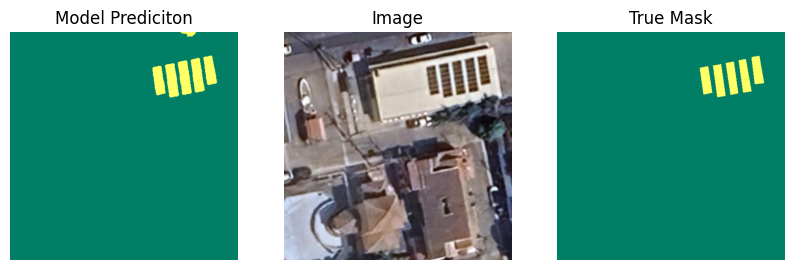

1/1 [==============================] - 0s 64ms/step


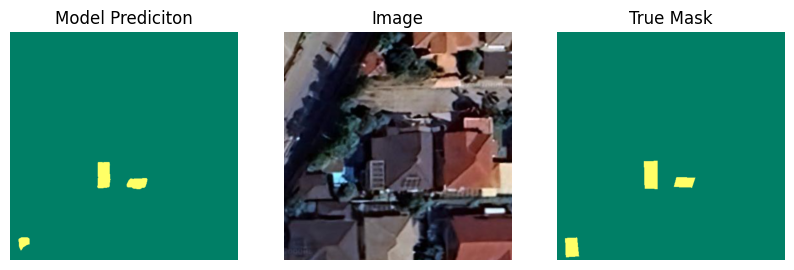

1/1 [==============================] - 0s 45ms/step


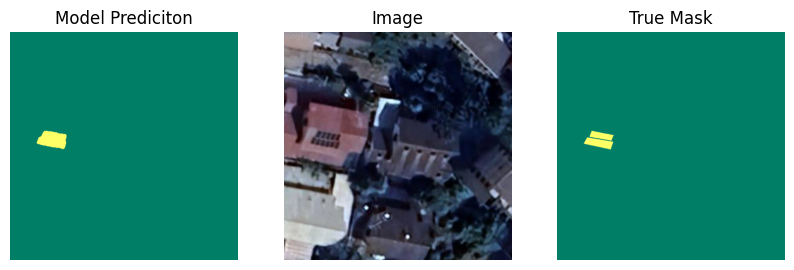

In [26]:
threshold = 0.9

for item in test_dataset.shuffle(101).take(10):
        image = item[0]     
        true_mask = item[1]
        mask_4d = model.predict(np.expand_dims(image, axis=(0)))
        pred_mask_proba = np.squeeze(mask_4d, axis=0)
        pred_mask = np.where(pred_mask_proba > threshold, 1, 0)
        
        image_converted = (image + 1) / 2

        show_images(
            (pred_mask, image_converted, true_mask), 
            ["Model Prediciton", "Image", "True Mask",]
        )

In [27]:
model.evaluate(test_dataset.batch(batch_size))

7/7 [==============================] - 12s 795ms/step - loss: 0.1791 - iou_score: 0.7458 - dice_coef: 0.8518 - binary_accuracy: 0.9956 - precision: 0.8763 - recall: 0.8702


[0.1790805459022522,
 0.7457758784294128,
 0.851783275604248,
 0.9956334233283997,
 0.8762742280960083,
 0.8702465295791626]